1. Resnet50

        Accuracy: 0.7979
        Classification Report:
                       precision    recall  f1-score   support

                    0       0.72      0.81      0.76       155
                    1       0.86      0.79      0.82       231

             accuracy                           0.80       386
            macro avg       0.79      0.80      0.79       386
         weighted avg       0.81      0.80      0.80       386

         model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/extra_forehead_wrinkle/model/model_v1/rgb_resnet50_1_wrinkle_classification_model_v5.pth'

2. DenseNet_orientation

        Accuracy: 0.9223
        Average Loss: 0.2687
        Classification Report:
                      precision    recall  f1-score   support

                   0       0.89      0.93      0.91       393
                   1       0.95      0.92      0.93       572

            accuracy                           0.92       965
           macro avg       0.92      0.92      0.92       965
        weighted avg       0.92      0.92      0.92       965

        model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_wrinkle/model/model_v2/DenseNet201_42_ensemble_orientation_1.pth'

3. DenseNet201_VGG19(앙상블 모델) + orientation
        n = 2490
        val_n = 965
        test_n = 965
        
        Accuracy: 0.9275
        Average Loss: 0.3614
        Classification Report:
                      precision    recall  f1-score   support

                   0       0.89      0.94      0.91       393
                   1       0.95      0.92      0.94       572

            accuracy                           0.93       965
           macro avg       0.92      0.93      0.93       965
        weighted avg       0.93      0.93      0.93       965

        model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_wrinkle/model/model_v2/DenseNet201_VGG19_42_ensemble_2.pth'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Resnet50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)
            for folder in image_folder:
                for image_file in os.listdir(folder):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder, image_file)
                        image_id = image_file.split('_')[0]
                        label_data = df[df['ID'] == int(image_id)]['forehead_wrinkle'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
image_folder = ['/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/train/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/val/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/smart_pad',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad'
                ]

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=1)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p = 0.3)  # 50% 드롭아웃
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([1.0, 2.0], dtype=torch.float32).to(device)

num_classes = 2  # 색소침착 등급이 3개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/extra_forehead_wrinkle/model/model_v1/rgb_resnet50_1_wrinkle_classification_model_v5.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Epoch [1/50], Train Loss: 0.5300, Train Accuracy: 0.5874, Val Loss: 0.4846, Val Accuracy: 0.5984
Epoch [2/50], Train Loss: 0.3604, Train Accuracy: 0.5939, Val Loss: 0.4720, Val Accuracy: 0.6632
Epoch [3/50], Train Loss: 0.2519, Train Accuracy: 0.8148, Val Loss: 0.4350, Val Accuracy: 0.7694
Epoch [4/50], Train Loss: 0.1098, Train Accuracy: 0.9780, Val Loss: 0.6224, Val Accuracy: 0.7746
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.0542, Train Accuracy: 0.9812, Val Loss: 0.6577, Val Accuracy: 0.7591
EarlyStopping counter: 2 out of 5
Epoch [6/50], Train Loss: 0.0495, Train Accuracy: 0.9825, Val Loss: 0.7548, Val Accuracy: 0.7979
EarlyStopping counter: 3 out of 5
Epoch [7/50], Train Loss: 0.0597, Train Accuracy: 0.9825, Val Loss: 0.8212, Val Accuracy: 0.7824
EarlyStopping counter: 4 out of 5
Epoch [8/50], Train Loss: 0.0334, Train Accuracy: 0.9890, Val Loss: 0.8122, Val Accuracy: 0.7850
EarlyStopping counter: 5 out of 5
Early stopping


Accuracy: 0.7979
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       155
           1       0.86      0.79      0.82       231

    accuracy                           0.80       386
   macro avg       0.79      0.80      0.79       386
weighted avg       0.81      0.80      0.80       386



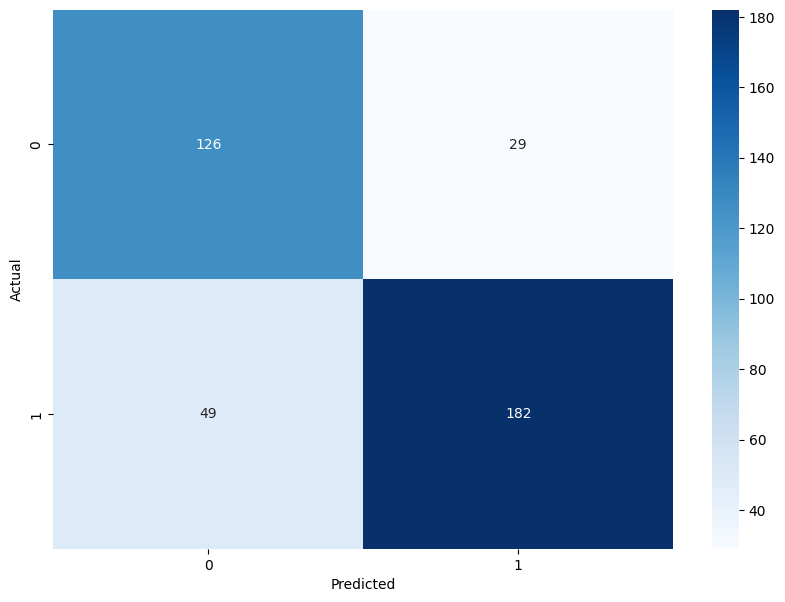

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 평가
model.eval()
# 검증 데이터셋에 대한 예측
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DenseNet_orientation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import DenseNet121_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)
            for folder in image_folder:
                for image_file in os.listdir(folder):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder, image_file)
                        image_id = image_file.split('_')[0]
                        label_data = df[df['ID'] == int(image_id)]['forehead_wrinkle'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
train_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/forehead_origin',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/horizon'
                ]

val_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/smart_pad',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/train/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/val/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad',
                ]

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋 생성
train_dataset = SkinDataset(csv_file=csv_file, image_folder  = train_image_folder, transform=transform)
val_dataset = SkinDataset(csv_file=csv_file, image_folder=val_image_folder, transform=transform)

# Validation 및 Test 데이터셋 분할
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    val_dataset.image_paths, val_dataset.labels, test_size=0.5, random_state=42, stratify=val_dataset.labels
)

# Validation 및 Test 데이터셋 생성
validation_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)
test_dataset = SkinDataset(image_paths=test_image_paths, labels=test_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=3)
val_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=3)

# DenseNet 기반 모델 정의
class DenseNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetforClassification, self).__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.dropout = nn.Dropout(p = 0.4)  # 40% 드롭아웃
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

# `device` 변수 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([1.2, 2.0], dtype=torch.float32).to(device)

num_classes = 2  # 주름 분류를 위한 클래스 수 (0과 1)
model = DenseNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_wrinkle/model/model_v2/DenseNet201_42_ensemble_orientation_1.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s]


Epoch [1/50], Train Loss: 0.4712, Train Accuracy: 0.7229, Val Loss: 0.3201, Val Accuracy: 0.8301
Epoch [2/50], Train Loss: 0.3660, Train Accuracy: 0.8153, Val Loss: 0.2931, Val Accuracy: 0.8611
Epoch [3/50], Train Loss: 0.2795, Train Accuracy: 0.8702, Val Loss: 0.2302, Val Accuracy: 0.9109
Epoch [4/50], Train Loss: 0.2053, Train Accuracy: 0.9078, Val Loss: 0.2467, Val Accuracy: 0.9171
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.1403, Train Accuracy: 0.9431, Val Loss: 0.2083, Val Accuracy: 0.9223
Epoch [6/50], Train Loss: 0.0890, Train Accuracy: 0.9653, Val Loss: 0.2587, Val Accuracy: 0.9275
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.0738, Train Accuracy: 0.9697, Val Loss: 0.2581, Val Accuracy: 0.9192
EarlyStopping counter: 2 out of 5
Epoch [8/50], Train Loss: 0.0535, Train Accuracy: 0.9825, Val Loss: 0.2078, Val Accuracy: 0.9358
Epoch [9/50], Train Loss: 0.0396, Train Accuracy: 0.9857, Val Loss: 0.2237, Val Accuracy: 0.9409
EarlyStopping counter: 1 

Accuracy: 0.9223
Average Loss: 0.2687
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       393
           1       0.95      0.92      0.93       572

    accuracy                           0.92       965
   macro avg       0.92      0.92      0.92       965
weighted avg       0.92      0.92      0.92       965



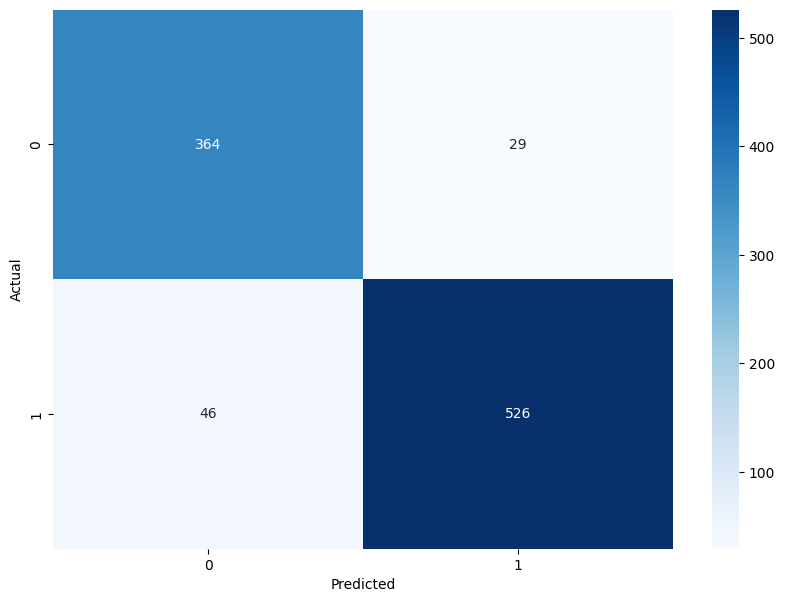

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# 모델 평가
model.eval()
# 검증 데이터셋에 대한 예측
true_labels = []
predicted_labels = []
all_losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # 손실 계산
        loss = F.cross_entropy(outputs, labels)
        all_losses.append(loss.item())

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
average_loss = sum(all_losses) / len(all_losses)

print(f'Accuracy: {accuracy:.4f}')
print(f'Average Loss: {average_loss:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DenseNet201_VGG19

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import DenseNet201_Weights, VGG19_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)
            for folder in image_folder:
                for image_file in os.listdir(folder):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder, image_file)
                        image_id = image_file.split('_')[0]
                        label_data = df[df['ID'] == int(image_id)]['forehead_wrinkle'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
image_folder = ['/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/train/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/val/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/smart_pad',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad'
                ]

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=8)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=3)

# 앙상블 모델 정의
class DenseNet201_VGG19_Ensemble(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet201_VGG19_Ensemble, self).__init__()

        # DenseNet201 정의
        self.densenet = models.densenet201(weights=DenseNet201_Weights.DEFAULT)
        densenet_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # 최종 분류기를 제거하고 특징만 추출

        # VGG19 정의
        self.vgg = models.vgg19(weights=VGG19_Weights.DEFAULT)
        vgg_features = self.vgg.classifier[0].in_features
        self.vgg.classifier = nn.Identity()  # 최종 분류기를 제거하고 특징만 추출

        # 두 모델의 특징을 결합하는 계층
        self.classifier = nn.Sequential(
            nn.Linear(densenet_features + vgg_features, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # DenseNet201 특징 추출
        densenet_features = self.densenet(x)

        # VGG19 특징 추출
        vgg_features = self.vgg(x)

        # 두 특징을 결합
        combined_features = torch.cat((densenet_features, vgg_features), dim=1)

        # 최종 분류
        output = self.classifier(combined_features)
        return output

# `device` 변수 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([1.2, 2.0], dtype=torch.float32).to(device)

num_classes = 2  # 주름 분류를 위한 클래스 수 (0과 1)
model = DenseNet201_VGG19_Ensemble(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/extra_forehead_wrinkle/model/model_v2/DenseNet201_VGG19_8_ensemble_model_v4.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Epoch [1/50], Train Loss: 0.5323, Train Accuracy: 0.6159, Val Loss: 0.4267, Val Accuracy: 0.6684
Epoch [2/50], Train Loss: 0.4166, Train Accuracy: 0.7558, Val Loss: 0.3880, Val Accuracy: 0.8290
Epoch [3/50], Train Loss: 0.3683, Train Accuracy: 0.8161, Val Loss: 0.3452, Val Accuracy: 0.8342
Epoch [4/50], Train Loss: 0.2965, Train Accuracy: 0.8588, Val Loss: 0.3210, Val Accuracy: 0.8368
Epoch [5/50], Train Loss: 0.2192, Train Accuracy: 0.8970, Val Loss: 0.3270, Val Accuracy: 0.8653
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 0.1407, Train Accuracy: 0.9514, Val Loss: 0.3882, Val Accuracy: 0.8394
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.0622, Train Accuracy: 0.9793, Val Loss: 0.4951, Val Accuracy: 0.8446
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Loss: 0.0228, Train Accuracy: 0.9961, Val Loss: 0.6153, Val Accuracy: 0.8187
EarlyStopping counter: 4 out of 5
Epoch [9/50], Train Loss: 0.0078, Train Accuracy: 0.9994, Val Loss: 0.6944, Val Accuracy

Accuracy: 0.8653
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       161
           1       0.89      0.87      0.88       225

    accuracy                           0.87       386
   macro avg       0.86      0.86      0.86       386
weighted avg       0.87      0.87      0.87       386



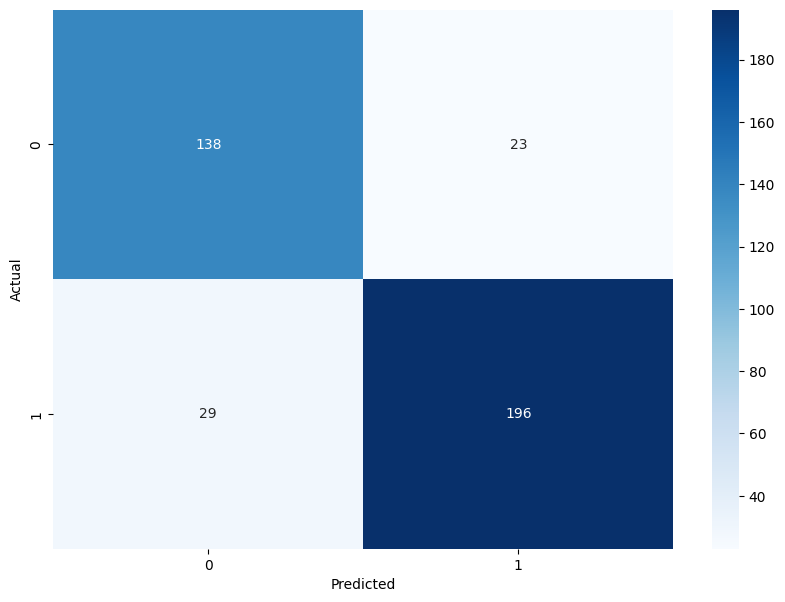

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 평가
model.eval()
# 검증 데이터셋에 대한 예측
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DenseNet201_VGG19 + orientation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import DenseNet201_Weights, VGG19_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)
            for folder in image_folder:
                for image_file in os.listdir(folder):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder, image_file)
                        image_id = image_file.split('_')[0]
                        label_data = df[df['ID'] == int(image_id)]['forehead_wrinkle'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
train_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/color_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_minus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/rotation_plus_10',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/forehead_origin',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/horizon'
                ]

val_image_folder = [
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/forehead/smart_pad',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/train/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Origin/val/forehead',
                '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/forehead/smart_pad',
                ]

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋 생성
train_dataset = SkinDataset(csv_file=csv_file, image_folder  = train_image_folder, transform=transform)
val_dataset = SkinDataset(csv_file=csv_file, image_folder=val_image_folder, transform=transform)

# Validation 및 Test 데이터셋 분할
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    val_dataset.image_paths, val_dataset.labels, test_size=0.5, random_state=42, stratify=val_dataset.labels
)

# Validation 및 Test 데이터셋 생성
validation_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)
test_dataset = SkinDataset(image_paths=test_image_paths, labels=test_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=3)
val_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=3)

# 앙상블 모델 정의
class DenseNet201_VGG19_Ensemble(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet201_VGG19_Ensemble, self).__init__()

        # DenseNet201 정의
        self.densenet = models.densenet201(weights=DenseNet201_Weights.DEFAULT)
        densenet_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # 최종 분류기를 제거하고 특징만 추출

        # VGG19 정의
        self.vgg = models.vgg19(weights=VGG19_Weights.DEFAULT)
        vgg_features = self.vgg.classifier[0].in_features
        self.vgg.classifier = nn.Identity()  # 최종 분류기를 제거하고 특징만 추출

        # 두 모델의 특징을 결합하는 계층
        self.classifier = nn.Sequential(
            nn.Linear(densenet_features + vgg_features, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # DenseNet201 특징 추출
        densenet_features = self.densenet(x)

        # VGG19 특징 추출
        vgg_features = self.vgg(x)

        # 두 특징을 결합
        combined_features = torch.cat((densenet_features, vgg_features), dim=1)

        # 최종 분류
        output = self.classifier(combined_features)
        return output

# `device` 변수 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([1.2, 2.0], dtype=torch.float32).to(device)

num_classes = 2  # 주름 분류를 위한 클래스 수 (0과 1)
model = DenseNet201_VGG19_Ensemble(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ensemble/extra_forehead_wrinkle/model/model_v2/DenseNet201_VGG19_42_ensemble_2.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Epoch [1/50], Train Loss: 0.4721, Train Accuracy: 0.7019, Val Loss: 0.3599, Val Accuracy: 0.8104
Epoch [2/50], Train Loss: 0.3553, Train Accuracy: 0.8212, Val Loss: 0.3001, Val Accuracy: 0.8684
Epoch [3/50], Train Loss: 0.2367, Train Accuracy: 0.8897, Val Loss: 0.2020, Val Accuracy: 0.9233
Epoch [4/50], Train Loss: 0.1256, Train Accuracy: 0.9469, Val Loss: 0.2220, Val Accuracy: 0.9202
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.0745, Train Accuracy: 0.9717, Val Loss: 0.1902, Val Accuracy: 0.9295
Epoch [6/50], Train Loss: 0.0311, Train Accuracy: 0.9915, Val Loss: 0.2626, Val Accuracy: 0.9337
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.0300, Train Accuracy: 0.9880, Val Loss: 0.2238, Val Accuracy: 0.9420
EarlyStopping counter: 2 out of 5
Epoch [8/50], Train Loss: 0.0175, Train Accuracy: 0.9939, Val Loss: 0.2721, Val Accuracy: 0.9440
EarlyStopping counter: 3 out of 5
Epoch [9/50], Train Loss: 0.0056, Train Accuracy: 0.9991, Val Loss: 0.2985, Val Accuracy

Accuracy: 0.9275
Average Loss: 0.3614
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       393
           1       0.95      0.92      0.94       572

    accuracy                           0.93       965
   macro avg       0.92      0.93      0.93       965
weighted avg       0.93      0.93      0.93       965



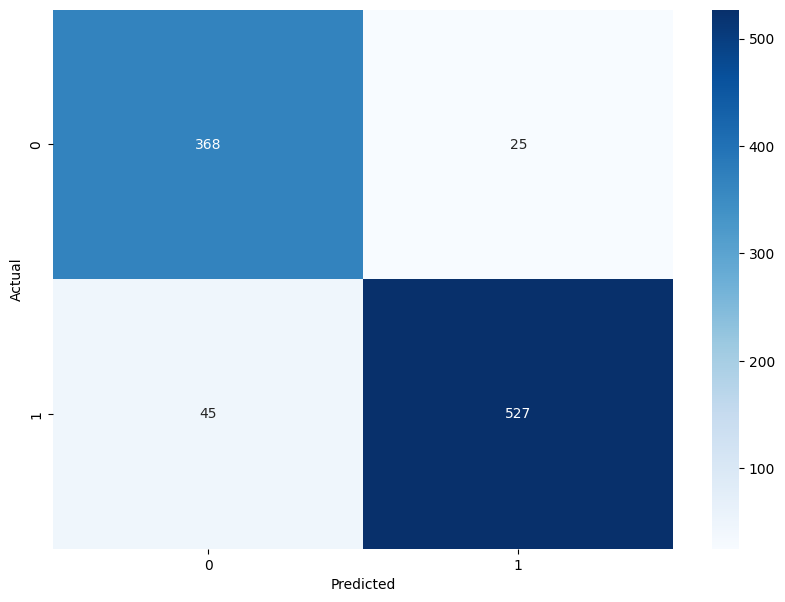

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# 모델 평가
model.eval()
# 검증 데이터셋에 대한 예측
true_labels = []
predicted_labels = []
all_losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # 손실 계산
        loss = F.cross_entropy(outputs, labels)
        all_losses.append(loss.item())

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
average_loss = sum(all_losses) / len(all_losses)

print(f'Accuracy: {accuracy:.4f}')
print(f'Average Loss: {average_loss:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()